In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
import keras
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom
from stochastic.processes.continuous import FractionalBrownianMotion

%load_ext autoreload
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-05-06 15:14:31.120656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 15:14:31.662775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jwoo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-06 15:14:32.771726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 15:14:32.813223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 15:14:32.813280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
SHUFFLE = True
MAX_EPOCHS = 10000
BATCH_SIZE = 1024
PATIENCE = 100
N = 10
T = 200
L = None

NB_INPUT_FEATURES = 1
SEARCH_WIDTH = 2
WINDOW_WIDTHS = [36, 48, 60, 72, 84]
SHIFT_WIDTH = 30
JUMP_D = 15

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [4]:
def make_signal(x_pos, y_pos, win_widths, search_width):
    all_vals = []
    for win_width in win_widths:
        if win_width > len(x_pos):
            continue
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 / win_width
            xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 / win_width 
            ys2 = ys2 / win_width

            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.concatenate((np.zeros(int(win_width/2)), vals))
        vals = np.concatenate((vals, np.zeros(int(win_width/2))))
        vals = np.array(vals)
        all_vals.append(vals)
    
    all_vals = np.array(all_vals) + 1e-5
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return np.vstack((all_vals, normalized_vals))

In [5]:
def slice_data(signal_seq, jump_d=15):
    slice_d = []
    indice = []
    std_signal = np.std(signal_seq, axis=1).reshape(-1, 1)
    mean_signal = np.mean(signal_seq, axis=1).reshape(-1, 1)
    for i in range(SHIFT_WIDTH//2, signal_seq.shape[1] - SHIFT_WIDTH//2, jump_d):
        crop = signal_seq[:, i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
        crop = np.hstack((crop, mean_signal))
        crop = np.hstack((crop, std_signal))
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice)

In [6]:
def merge_close_points(changepoints, signals, seuil=5):
    seq_sums = []
    for i in range(len(signals)):
        tmp = []
        for j in range(len(signals[i])):
            if j < SEARCH_WIDTH:
                tmp.append(signals[i][j] * ((SEARCH_WIDTH * 2) + 1))
            elif j > len(signals[i]) - 1 - SEARCH_WIDTH:
                tmp.append(signals[i][j] * ((SEARCH_WIDTH * 2) + 1))
            else:
                tmp.append(np.sum(signals[i][j-SEARCH_WIDTH:j+SEARCH_WIDTH+1]))
        tmp = np.array(tmp)
        seq_sums.append(tmp)
    seq_sums = np.array(seq_sums)
    seq_sums = np.sum(seq_sums, axis=0)
    val_orders = np.argsort(seq_sums[changepoints])[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [7]:
def ana_cp_predict(x, y, win_widths, search_width, jump_d):
    signal_seq = make_signal(x, y, win_widths, search_width)
    predict_input, indice = slice_data(signal_seq, jump_d=jump_d)
    activ_nb_win = np.sum(np.array(win_widths) <= np.array([len(x)] * len(win_widths)))
    if activ_nb_win > 0:
        predict_input = np.array(predict_input).reshape(-1, activ_nb_win*2, SHIFT_WIDTH+2, 1)
        pred = classification_model.predict(predict_input, verbose=0).flatten()
        cps = indice[np.round(pred) >= 1]
        if len(cps) == 0:
            return []
        reg_inputs = []
        for cp in cps:
            reg_inputs.append(signal_seq[:, cp - (SHIFT_WIDTH//2): cp + (SHIFT_WIDTH//2)])
        reg_inputs = np.array(reg_inputs).reshape(-1, activ_nb_win*2, SHIFT_WIDTH, 1)
        reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
        cps = np.round(cps + reg_outputs).astype(int)
        cps = merge_close_points(cps, signal_seq)
        return np.sort(cps)
    else:
        return []

In [8]:
@tf.keras.utils.register_keras_serializable()
class Jaccard(tf.keras.Metric):
    def __init__(self, name='JSC', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_tp'
        )
        self.false_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fp'
        )
        self.false_negatives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fn'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(tf.math.round(y_pred), "bool")

        tp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        tp_values = tf.keras.ops.cast(tp_values, self.dtype)
        
        fp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        fp_values = tf.keras.ops.cast(fp_values, self.dtype)
        
        fn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        fn_values = tf.keras.ops.cast(fn_values, self.dtype)
        
        tn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        tn_values = tf.keras.ops.cast(tn_values, self.dtype)

        self.true_positives.assign(self.true_positives + tf.keras.ops.sum(tp_values))
        self.false_positives.assign(self.false_positives + tf.keras.ops.sum(fp_values))
        self.false_negatives.assign(self.false_negatives + tf.keras.ops.sum(fn_values))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + self.false_negatives)

In [9]:
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
classification_model = tf.keras.models.load_model('classification_model_0.keras')
#classification_model.summary()
regression_model = tf.keras.models.load_model('regression_model_0.keras')
#regression_model.summary()

TensorFlow version: 2.16.1


2024-05-06 15:14:35.021133: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 15:14:35.021280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 15:14:35.021341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 15:14:35.174321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 15:14:35.174390: I external/local_xla/xla/stream_executor

2024-05-06 15:14:40.442912: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1715001280.957392  181086 service.cc:145] XLA service 0x55cc4715b040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715001280.957436  181086 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-06 15:14:40.984032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715001281.396557  181086 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(10, 190)
[ 34  70  91 122]


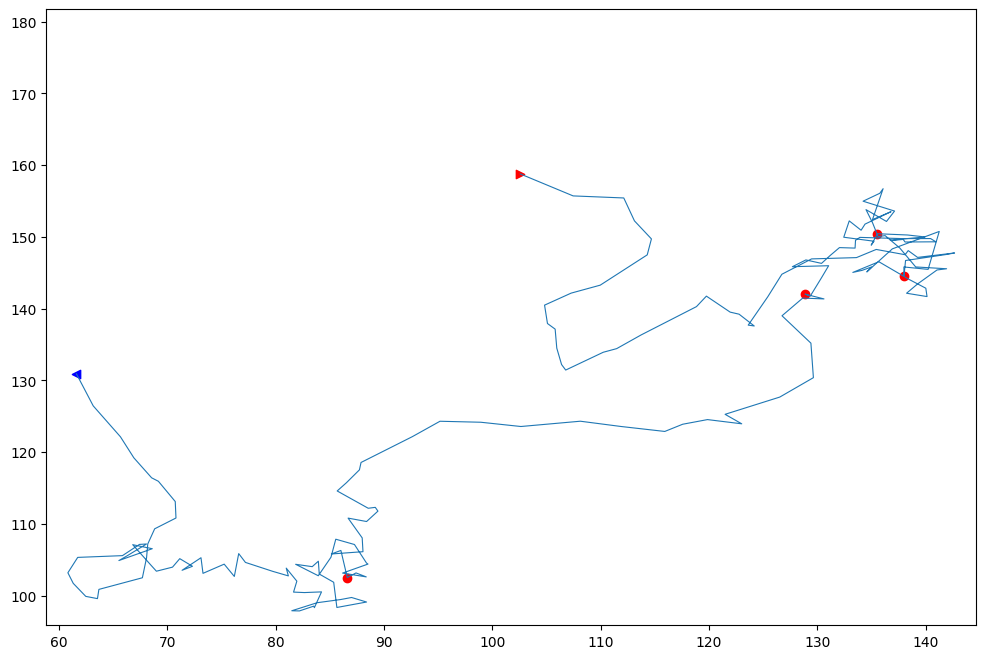

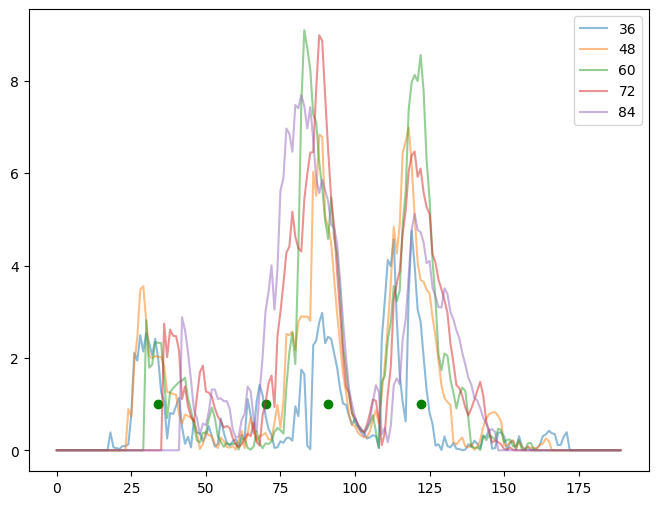

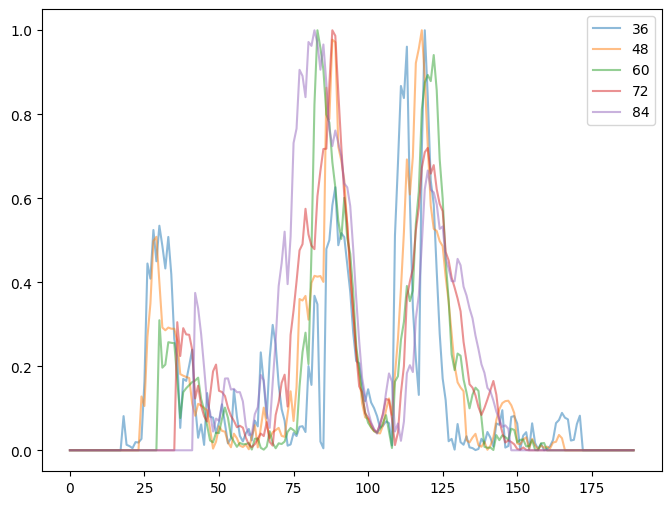

In [10]:
# Define the number of experiments and number of FOVS

track = 2
exp = 3
fovs = [0]
traj_idx = [11]

        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')

    for idx in traj_idx:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]

            # Assign one changepoints for each traj at 0.25 of its length
        cps = ana_cp_predict(x, y, WINDOW_WIDTHS, SEARCH_WIDTH, JUMP_D)
        #cps = np.concatenate((cps, [length_traj])).astype(int)

        signals = make_signal(x, y, WINDOW_WIDTHS, SEARCH_WIDTH)
        print(signals.shape)
        print(cps)
        plt.figure(figsize=(12, 8))
        plt.plot(x, y, linewidth=0.8)
        for cp in cps:
            plt.scatter(x[cp], y[cp], c='red')

        plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        plt.scatter(x[0], y[0], marker='>', c='red')
        plt.scatter(x[-1], y[-1], marker='<', c='blue')

        plt.figure()
        for i in range(0, signals.shape[0]//2):
            plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.5, label=f'{WINDOW_WIDTHS[i]}')
        plt.scatter(cps, np.array([1] * len(cps)), c='green')
        plt.legend()
        #plt.ylim([0, 10])
        
        plt.figure()
        for i in range(0, signals.shape[0]//2):
            plt.plot(np.arange(signals.shape[1]), signals[i + signals.shape[0]//2], alpha=0.5, label=f'{WINDOW_WIDTHS[i]}')
        plt.legend()

    

